# k-nearest-Neighbour

## Load datasets

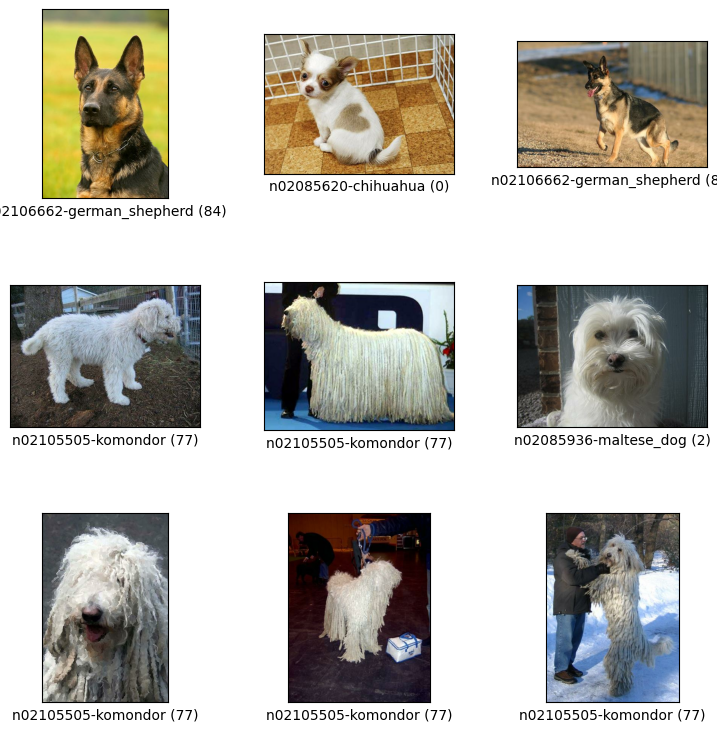

/var/folders/pb/8wrfvtz5593cjrgr_g89r70m0000gn/T/ipykernel_37448/1680334725.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [110]:
import tensorflow_datasets as tfds
import tensorflow as tf
from pathlib import Path
import sys

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from setup import setup_dataset


train_dataset, test_dataset, metadata = setup_dataset('../dataset')

fig = tfds.show_examples(train_dataset, metadata)
fig.show()

## Merkmale
Die folgenden Merkmale wurden zur Merkmalsextraktion definiert:
https://gvpress.com/journals/IJMUE/vol8_no4/39.pdf

Farb-merkmale:
1. Helligkeit des Fells
2. Farbvarianz des Fells

Textur-merkmale:

3. Fellstruktur

Form-merkmale:

4. Form des Hunds auf dem Bild




Ideen:
- Histogramm
    - Maximaler Wert
    - Median
    - Mittelwert
    - Kurtosis
- Rechtecke
    - Anzahl der gefundenen Regionen
    - Avg(Höhe)/Avg(Breite)
    - Avg(Höhe)
    - Avg(Breite)

- 



<class 'numpy.ndarray'>


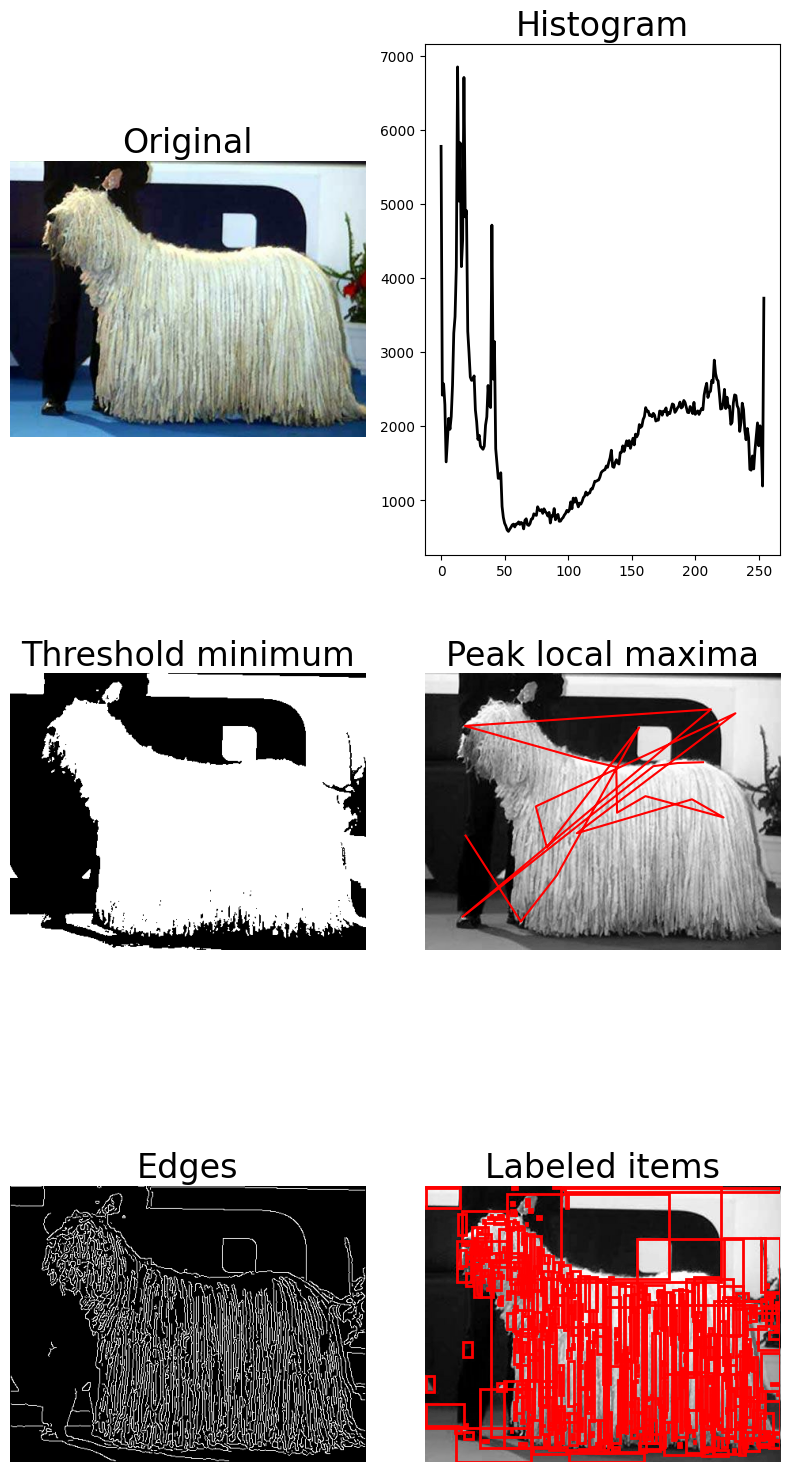

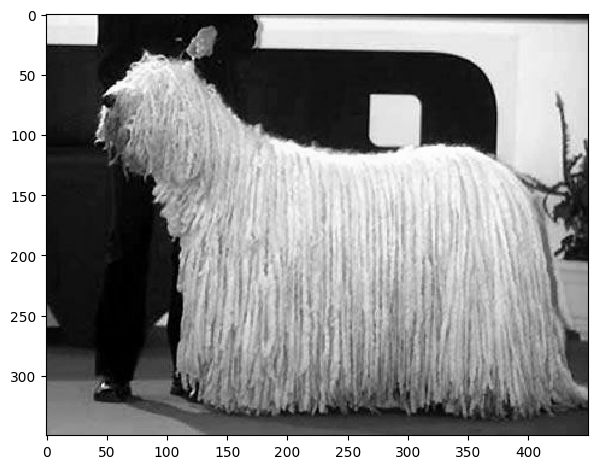

In [114]:
import cv2
import matplotlib.pyplot as plt
from skimage import filters, feature
from skimage.io import imshow
import numpy as np

"""for img, label in train_dataset:
    img_grayscale = tf.image.rgb_to_grayscale(img)
    img_np = img_grayscale.cpu().numpy()[:,:,0]
    img_canny = feature.canny(img_np)
    imshow(img_canny)"""

img = [element for element in train_dataset.take(5)][4][0]
img_grayscale = tf.image.rgb_to_grayscale(img)

img_np = img.numpy()
img_grayscale_np = img_grayscale.cpu().numpy()[:,:,0]


fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(8, 16))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flat


# Original anzeigen
ax0.imshow(img)
ax0.set_title("Original", fontsize=24)
ax0.axis("off")


# Histogram anzeigen
values, bins = np.histogram(img, bins=np.arange(256))
print(type(values))
ax1.plot(bins[:-1], values, lw=2, c="k")
ax1.set_title("Histogram", fontsize=24)
fig.set_tight_layout(tight=True)


# Divide Foreground and Background
from skimage.filters import threshold_minimum, try_all_threshold
threshold = threshold_minimum(img_grayscale_np, 95)
binary = img_grayscale > threshold
ax2.imshow(binary, cmap=plt.cm.gray)
ax2.set_title("Threshold minimum", fontsize=24)
ax2.axis("off")

# Maximum
from skimage.feature import peak_local_max
coordinates = peak_local_max(img_grayscale_np, min_distance=30)
ax3.imshow(img_grayscale_np, cmap=plt.cm.gray)
ax3.autoscale(False)
ax3.plot(coordinates[:,1],
         coordinates[:,0], c=(1.0,0.0,0.0))
ax3.set_title("Peak local maxima", fontsize=24)
ax3.axis("off")

# Canny filter
from skimage.feature import canny

edges = canny(img_grayscale_np)
ax4.imshow(edges, cmap=plt.cm.gray)
ax4.set_title("Edges", fontsize=24)
ax4.axis("off")

# image labeling
from skimage.measure import regionprops
import matplotlib.patches as mpatches
from skimage.morphology import label

label_image = label(edges)

ax5.imshow(img_grayscale_np, cmap=plt.cm.gray)
ax5.set_title("Labeled items", fontsize=24)
ax5.axis("off")

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect=mpatches.Rectangle((minc, minr),maxc-minc, maxr-minr, fill=False, edgecolor="red", linewidth=2)
    ax5.add_patch(rect)

plt.tight_layout()
plt.show()




img_grayscale = tf.image.rgb_to_grayscale(img)
img_np = img_grayscale.cpu().numpy()[:,:,0]
img_canny = feature.canny(img_np)
imshow(img_np)

# Creating feature vector

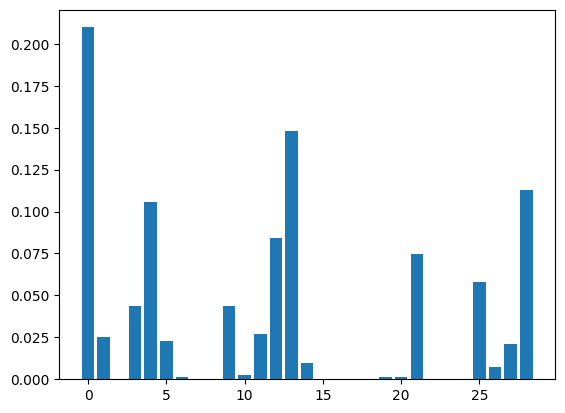

[0.20985915 0.02535211 0.         0.04366197 0.1056338  0.02253521
 0.00140845 0.         0.         0.04366197 0.0028169  0.02676056
 0.08450704 0.14788732 0.00985915 0.         0.         0.
 0.         0.00140845 0.00140845 0.07464789 0.         0.
 0.         0.05774648 0.00704225 0.02112676 0.11267606]
(350, 450)
(157500,)


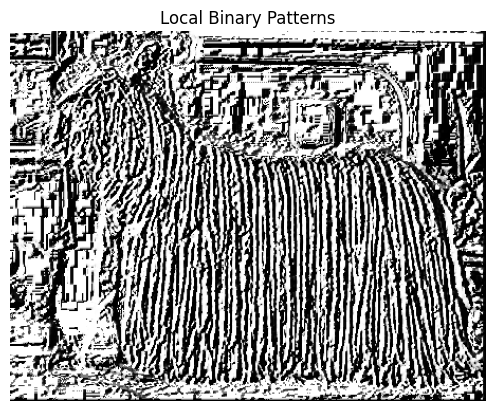

In [138]:
from skimage.feature import local_binary_pattern
import scipy.stats as ss
from skimage.measure import regionprops_table
import matplotlib.patches as mpatches
from skimage.morphology import label
from skimage.feature import canny
import pandas as pd

def colorTensor2grayNparray(image):
    return tf.image.rgb_to_grayscale(image).cpu().numpy()[:,:,0]


def computeHistogrammFeatures(img):
    values, _ = np.histogram(img, bins=np.arange(256))
    nobs, minmax, mean, variance, skewness, kurtosis = ss.describe(values)
    return mean, skewness, kurtosis


def computeRegionFeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)

    edges = canny(img_grayscale_np)
    label_image = label(edges)

    properties=("bbox", "area_bbox", "axis_major_length", "axis_minor_length", "orientation", "solidity")
    regions = regionprops_table(label_image,properties=properties)
    df = pd.DataFrame(regions)

    num_regions = df.shape[0]
    df["bbox_height_width_ratio"] = (df["bbox-3"]-df["bbox-1"])/(df["bbox-2"]-df["bbox-0"])
    df["axis_ratio"] = (df["axis_major_length"])/(df["axis_minor_length"])
    df = df.drop(columns=["bbox-0","bbox-1", "bbox-2", "bbox-3"])
    df = df.describe()

    return (
        num_regions,
        df.at["mean", "bbox_height_width_ratio"],
        df.at["std", "orientation"],
    )

def computeLBPfeatures(img):
    img_grayscale_np = colorTensor2grayNparray(img)
    radius = 3
    n_points = radius*10
    lbp = local_binary_pattern(img_grayscale_np, n_points, radius)

    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(3,n_points+3), range=(5, n_points+2))
    hist = hist.astype("float")
    hist/=hist.sum()
    plt.bar(range(len(hist)), hist)
    plt.show()
    print(hist)
    print(lbp.shape)
    print(lbp.ravel().shape)




    plt.imshow(lbp, cmap="gray")
    plt.title("Local Binary Patterns")
    plt.axis("off")
    plt.show()


# TODO: compute more attributes of feature vector, then create feature vector -> reduction, selection etc.


# for region in regionprops(label_image):
#    minr, minc, maxr, maxc = region.bbox
#    rect=mpatches.Rectangle((minc, minr),maxc-minc, maxr-minr, fill=False, edgecolor="red", linewidth=2)
#    ax5.add_patch(rect)


computeLBPfeatures(img)